# Show samples from GP for infinitely wide single layer NN (Williams 1996)

Written by Matthias Bauer


In [1]:
import jax.numpy as jnp
import jax
from jax.config import config

# need 64bit computation for kernel + cholesky
config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt

In [17]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [18]:
try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    print("installing probml-utils")
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

# latexify(width_scale_factor=2, fig_height=1.5)  # for book
latexify(fig_height=2)  # for book

installing probml-utils
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 125 kB 32.7 MB/s 
     |████████████████████████████████| 272 kB 51.9 MB/s 
     |████████████████████████████████| 72 kB 520 kB/s 
     |████████████████████████████████| 1.1 MB 35.9 MB/s 


/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [2]:
def kernel_nn(x, y, sigma_0, sigma, sigma_b=0.0):
    """Neural network covariance function for infinitely wide NN of the form
    ```
        f(x) = b + sum_i^I v_i * h(x, u_i)

    where
        b ~ N(0, sigma_b)
        v_i ~ N(0, 1/sqrt(I))  # scales as 1/width to have well defined limit
        h(x, u) = erf(x * u + u_0)
        u ~ N(0, sigma)
        u_0 ~ N(0, sigma_0)
    ```

    Equation (9) and (11) in https://proceedings.neurips.cc/paper/1996/file/ae5e3ce40e0404a45ecacaaf05e5f735-Paper.pdf

    Args:
      x: Inputs
      y: Inputs
      sigma_0: std of the bias inside the activation/erf
      sigma: std of the weight inside the activation/erf
      sigma_b: std of the overall bias
    """
    x = jnp.array([1.0, x])  # add bias
    y = jnp.array([1.0, y])  # add bias
    S = jnp.diag(jnp.array([sigma_0**2, sigma**2]))
    xSy = jnp.einsum("i,ij,j->", x, S, y)
    xSx = jnp.einsum("i,ij,j->", x, S, x)
    ySy = jnp.einsum("i,ij,j->", y, S, y)
    arg = 2.0 * xSy / jnp.sqrt((1 + 2 * xSx) * (1 + 2 * ySy))
    kernel = sigma_b**2 + 2.0 / jnp.pi * jnp.arcsin(arg)
    return kernel


# Vectorize kernel over both inputs x and y
kernel_nn_vec = jax.vmap(
    jax.vmap(kernel_nn, in_axes=(None, 0, None, None, None), out_axes=0),
    in_axes=(0, None, None, None, None),
    out_axes=0,
)

In [20]:
x = jnp.linspace(-5, 5, num=500)
jitter = 1e-8 * jnp.eye(len(x))  # even with 64-bit accuracy need jitter to keep kernel matrix positiv semi-definite

In [ ]:
rng = jax.random.PRNGKey(5)
# interesting seeds: 1, 5, 8

f, ax = plt.subplots(1, 2)
for sigma in [1, 3, 10]:
    # get shared randomness
    rng, used_rng = jax.random.split(rng)

    sigma0 = 0
    K = kernel_nn_vec(x, x, 0.0, sigma, sigma0) + jitter
    L = jnp.linalg.cholesky(K)
    y = jnp.einsum("ij,j->i", L, jax.random.normal(key=used_rng, shape=x.shape))
    ax[0].plot(x, y, label=f"$\sigma={sigma}$", lw=3)
    ax[0].legend(loc="upper right")
    ax[0].set_title(f"$\sigma_0 = {sigma0}$")

    sigma0 = 5
    K = kernel_nn_vec(x, x, sigma0, sigma, 0.0) + jitter
    L = jnp.linalg.cholesky(K)
    y = jnp.einsum("ij,j->i", L, jax.random.normal(key=used_rng, shape=x.shape))
    ax[1].plot(x, y, label=f"$\sigma={sigma}$", lw=3)
    ax[1].legend(loc="upper right")
    ax[1].set_title(f"$\sigma_0 = {sigma0}$")


savefig("nngp2")

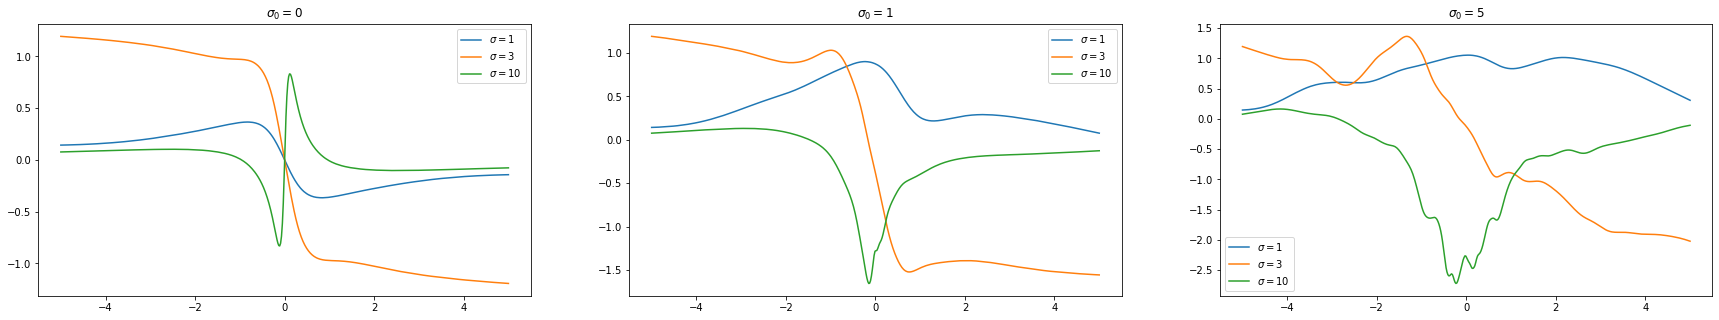

In [22]:
rng = jax.random.PRNGKey(5)
# interesting seeds: 1, 5, 8

f, ax = plt.subplots(1, 3)
for sigma in [1, 3, 10]:
    # get shared randomness
    rng, used_rng = jax.random.split(rng)

    sigma0 = 0
    K = kernel_nn_vec(x, x, 0.0, sigma, sigma0) + jitter
    L = jnp.linalg.cholesky(K)
    y = jnp.einsum("ij,j->i", L, jax.random.normal(key=used_rng, shape=x.shape))
    ax[0].plot(x, y, label=f"$\sigma={sigma}$", lw=3)
    ax[0].legend(loc="upper right")
    ax[0].set_title(f"$\sigma_0 = {sigma0}$")

    sigma0 = 2
    K = kernel_nn_vec(x, x, sigma0, sigma, 0.0) + jitter
    L = jnp.linalg.cholesky(K)
    y = jnp.einsum("ij,j->i", L, jax.random.normal(key=used_rng, shape=x.shape))
    ax[1].plot(x, y, label=f"$\sigma={sigma}$", lw=3)
    ax[1].legend(loc="upper right")
    ax[1].set_title(f"$\sigma_0 = {sigma0}$")

    sigma0 = 5
    K = kernel_nn_vec(x, x, sigma0, sigma, 0.0) + jitter
    L = jnp.linalg.cholesky(K)
    y = jnp.einsum("ij,j->i", L, jax.random.normal(key=used_rng, shape=x.shape))
    ax[2].plot(x, y, label=f"$\sigma={sigma}$", lw=3)
    ax[2].legend(loc="upper right")
    ax[2].set_title(f"$\sigma_0 = {sigma0}$")

savefig("nngp3")

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
